In [1]:
%matplotlib inline

from multiprocessing import cpu_count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import netCDF4
import xarray as xr

import datetime

seed = 1
np.random.seed(seed)

In [2]:
data = '/Users/wongnaret/lstm_data/eastern2/trainSet.nc'
smoothed_data = '/Users/wongnaret/lstm_data/central2_rmmeh/trainSet.nc'
shifted_data = '/Users/wongnaret/lstm_data/central2_rmmeh/shifted.nc'
       

In [3]:
ds1 = xr.open_dataset(data)
ds2 = xr.open_dataset(smoothed_data)
ds3 = xr.open_dataset(shifted_data)

In [4]:
ds1

<xarray.Dataset>
Dimensions:       (location: 177973, time: 75)
Coordinates:
  * time          (time) datetime64[ns] 2018-07-29 2018-08-05 ... 2019-12-29
    spatial_ref   int32 ...
    y             (location) uint16 ...
    row           (location) int64 ...
    col           (location) int64 ...
    latitude      (location) float64 ...
    longitude     (location) float64 ...
Dimensions without coordinates: location
Data variables: (12/15)
    coastal       (location, time) float32 ...
    blue          (location, time) float32 ...
    green         (location, time) float32 ...
    red           (location, time) float32 ...
    veg5          (location, time) float32 ...
    veg6          (location, time) float32 ...
    ...            ...
    water_vapour  (location, time) float32 ...
    swir1         (location, time) float32 ...
    swir2         (location, time) float32 ...
    SCL           (location, time) float32 ...
    WVP           (location, time) float32 ...
    AOT           (location, time) float32 ...

In [5]:
ds2

<xarray.Dataset>
Dimensions:       (location: 821345, time: 92)
Coordinates:
  * time          (time) datetime64[ns] 2018-04-08 2018-04-15 ... 2020-01-05
    spatial_ref   int32 ...
    y             (location) uint16 ...
    row           (location) int64 ...
    col           (location) int64 ...
    latitude      (location) float64 ...
    longitude     (location) float64 ...
Dimensions without coordinates: location
Data variables: (12/15)
    coastal       (location, time) float32 ...
    blue          (location, time) float32 ...
    green         (location, time) float32 ...
    red           (location, time) float32 ...
    veg5          (location, time) float32 ...
    veg6          (location, time) float32 ...
    ...            ...
    water_vapour  (location, time) float32 ...
    swir1         (location, time) float32 ...
    swir2         (location, time) float32 ...
    SCL           (location, time) float32 ...
    WVP           (location, time) float32 ...
    AOT           (location, time) float32 ...

In [6]:
ds3.sel(band='blue', location=1)

<xarray.Dataset>
Dimensions:       (crop_age: 112)
Coordinates:
    spatial_ref   int32 ...
    row           int64 ...
    col           int64 ...
    band          <U4 'blue'
  * crop_age      (crop_age) timedelta64[ns] -322 days -315 days ... 455 days
    merge_source  int64 ...
    latitude      float64 ...
    longitude     float64 ...
Data variables:
    x             (crop_age) float32 ...
    y             uint16 ...
    crop_start    datetime64[ns] ...

In [7]:
ds3

<xarray.Dataset>
Dimensions:       (band: 15, crop_age: 112, location: 821345)
Coordinates:
    spatial_ref   int32 4326
    row           (location) int64 ...
    col           (location) int64 ...
  * band          (band) object 'coastal' 'blue' 'green' ... 'SCL' 'WVP' 'AOT'
  * crop_age      (crop_age) timedelta64[ns] -322 days -315 days ... 455 days
    merge_source  int64 0
    latitude      (location) float64 ...
    longitude     (location) float64 ...
Dimensions without coordinates: location
Data variables:
    x             (location, band, crop_age) float32 ...
    y             (location) uint16 ...
    crop_start    (location) datetime64[ns] ...

In [8]:

def sampling_ds(ds, idx):
    coastal = ds['coastal'].sel(location = idx)/10000
    blue = ds['blue'].sel(location = idx)/10000
    green = ds['green'].sel(location = idx)/10000
    red = ds['red'].sel(location = idx)/10000
    veg5 = ds['veg5'].sel(location = idx)/10000
    veg6 = ds['veg6'].sel(location = idx)/10000
    veg7 = ds['veg7'].sel(location = idx)/10000
    nir = ds['nir'].sel(location = idx)/10000
    narrow_nir = ds['narrow_nir'].sel(location = idx)/10000
    water_vapour = ds['water_vapour'].sel(location = idx)/10000
    swir1 = ds['swir1'].sel(location = idx)/10000
    swir2 = ds['swir2'].sel(location = idx)/10000
    SCL = ds['SCL'].sel(location = idx)
    WVP = ds['WVP'].sel(location = idx)/1000
    AOT = ds['AOT'].sel(location = idx)/1000

    ndvi = (nir-red)/(nir+red+.00001)
    ndwi = (green-nir)/(green+nir+.00001)

    y = ds.y.sel(location=idx)
    
    tmp_array = np.array([coastal, blue, green, red, veg5, veg6, veg7, nir, 
                           narrow_nir, water_vapour, swir1, swir2, SCL, WVP, AOT,
                           ndvi, ndwi])
    
    i = ds.row.sel(location=idx)
    j = ds.col.sel(location=idx)
    position = np.array([i,j])
    
    lat = ds.latitude.sel(location=idx)
    lon = ds.longitude.sel(location=idx)
    location = np.array([lat,lon])
    
    return (tmp_array.transpose((1,0,2)), y.values, position.transpose(), location.transpose(), ds.time.values)

In [9]:

def sampling_shifted(ds, idx):
    coastal = ds.x.sel(band='coastal', location = idx)/10000
    blue = ds.x.sel(band='blue', location = idx)/10000
    green = ds.x.sel(band='green', location = idx)/10000
    red = ds.x.sel(band='red', location = idx)/10000
    veg5 = ds.x.sel(band='veg5', location = idx)/10000
    veg6 = ds.x.sel(band='veg6', location = idx)/10000
    veg7 = ds.x.sel(band='veg7', location = idx)/10000
    nir = ds.x.sel(band='nir', location = idx)/10000
    narrow_nir = ds.x.sel(band='narrow_nir', location = idx)/10000
    water_vapour = ds.x.sel(band='water_vapour', location = idx)/10000
    swir1 = ds.x.sel(band='swir1', location = idx)/10000
    swir2 = ds.x.sel(band='swir2', location = idx)/10000
    SCL = ds.x.sel(band='SCL', location = idx)
    WVP = ds.x.sel(band='WVP', location = idx)/1000
    AOT = ds.x.sel(band='AOT', location = idx)/1000

    ndvi = (nir-red)/(nir+red+.00001)
    ndwi = (green-nir)/(green+nir+.00001)

    y = ds.y.sel(location=idx)
    
    tmp_array = np.array([coastal, blue, green, red, veg5, veg6, veg7, nir, 
                           narrow_nir, water_vapour, swir1, swir2, SCL, WVP, AOT,
                           ndvi, ndwi])
    
    i = ds.row.sel(location=idx)
    j = ds.col.sel(location=idx)
    position = np.array([i,j])
    
    lat = ds.latitude.sel(location=idx)
    lon = ds.longitude.sel(location=idx)
    location = np.array([lat,lon])
    
    return (tmp_array.transpose((1,0,2)), y.values, position.transpose(), location.transpose(), ds.crop_age.values)

In [10]:
y = ds1.y.values

other_idx = np.random.choice(np.where(y ==0)[0], 50)
sugar_idx = np.random.choice(np.where(y ==1)[0], 50)
rice_idx = np.random.choice(np.where(y ==2)[0], 50)

(sugar, y, position, location, timestamp) = sampling_ds(ds1, rice_idx)  
(sugar_rmmeh, y, position, location, timestamp) = sampling_ds(ds2, rice_idx)  

In [21]:
tmp = ds1.y.values
tmp

array([0, 0, 0, ..., 1, 1, 1], dtype=uint16)

In [22]:
len(tmp)

177973

In [31]:
print(range(0, len(tmp)))

range(0, 177973)


In [11]:
(sugar_shifted, y, position, location, shifted_timestamp) = sampling_shifted(ds3, rice_idx)  

In [12]:
sugar.shape

(50, 17, 75)

In [13]:
sugar_rmmeh.shape

(50, 17, 92)

In [14]:
sugar_shifted.shape

(50, 17, 112)

In [15]:
sugar[1,-2,:].shape

(75,)

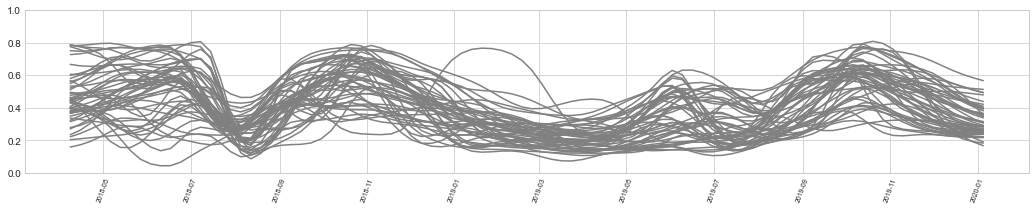

In [16]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
ax.set_ylim(top=1)
for idx in range(50):
    ax.plot(timestamp, sugar_rmmeh[idx,-2,:], color='grey');

plt.xticks(rotation=70, size=7)    
plt.show()

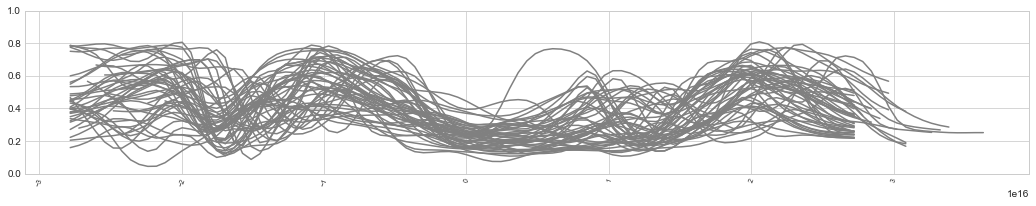

In [17]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
fig.set_size_inches(18, 3)
ax = plt.axes()
ax.set_ylim(top=1)
for idx in range(50):
    ax.plot(shifted_timestamp, sugar_shifted[idx,-2,:], color='grey');

plt.xticks(rotation=70, size=7)    
plt.show()